# SQLite and Plots

This second Jupyter Notebook will store cleaned data in a SQLite database, join SQLite tables, and explore plotting.

Importing libraries:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import sqlite3
import plotly.express as px

Importing cleaned data:

In [2]:
air_df = pd.read_csv("Air_quality_by_CD.csv")
tree_df = pd.read_csv("tree_summary_by_cb.csv")
boro_df = pd.read_csv("borough_tree.csv")

Creating a SQLite database and tables:

In [3]:
#Create SQLite database and tables
conn = sqlite3.connect("air_and_tree.db")
cursor = conn.cursor()

#create table air
cursor.execute("""
CREATE TABLE IF NOT EXISTS air (
    id TEXT NOT NULL,
    Name TEXT NOT NULL,
    Geo_Join_ID TEXT PRIMARY KEY,
    Time_Period TEXT NOT NULL,
    Data_Value REAL NOT NULL
);        
""")

#create table tree
cursor.execute(""" 
CREATE TABLE IF NOT EXISTS tree (
    tree_id TEXT NOT NULL,
    cb_num TEXT PRIMARY KEY,
    dbh_mean REAL NOT NULL,
    dbh_max INTEGER NOT NULL,
    tree_count INTEGER NOT NULL,
    avg_health_score REAL NOT NULL, 
    unique_species INTEGER NOT NULL
);             
""")

#insert data into tables
air_df.to_sql("air", conn, if_exists="replace", index=False)
tree_df.to_sql("tree", conn, if_exists="replace", index=False)

#verify data was inserted
print("Air Data Table: \n")
print(pd.read_sql_query("SELECT * FROM air LIMIT 5", conn))

print("Tree Data Table: \n")
print(pd.read_sql_query("SELECT * FROM tree LIMIT 5", conn))



Air Data Table: 

   id  Geo_Join_ID          Time_Period                    Name  Data_Value  \
0   1        304.0          Summer 2015  Nitrogen dioxide (NO2)        15.5   
1   2        410.0       Winter 2015-16  Nitrogen dioxide (NO2)        22.5   
2   3        301.0          Summer 2015  Nitrogen dioxide (NO2)        17.0   
3   4        409.0          Summer 2015  Nitrogen dioxide (NO2)        14.4   
4   5        304.0  Annual Average 2015  Nitrogen dioxide (NO2)        20.3   

  Measure_Info  
0          ppb  
1          ppb  
2          ppb  
3          ppb  
4          ppb  
Tree Data Table: 

   tree_id  cb_num  tree_count  avg_health_score  dbh_mean  dbh_max  \
0        1     101        2297            2.7101     7.096       88   
1        2     102        4833            2.6739     8.898       33   
2        3     103        4709            2.7084     8.449       32   
3        4     104        4419            2.7798     7.941       38   
4        5     105        2016 

In [4]:
#Create table boro 

cursor.execute("""
CREATE TABLE IF NOT EXISTS boro (
    boroname TEXT PRIMARY KEY,
    unique_species INTEGER NOT NULL,
    avg_dbh REAL NOT NULL,
    total_dbh REAL NOT NULL,
    avg_health_score REAL NOT NULL,
    total_trees INTEGER NOT NULL);
""")

boro_df.to_sql("boro", conn, if_exists= "replace", index=False)

print("Borough Table: \n")
print(pd.read_sql_query("""SELECT * FROM boro LIMIT 5;""", conn))


Borough Table: 

        boroname  unique_species  avg_dbh  total_dbh  avg_health_score  \
0          Bronx             132   10.083     812562            2.7881   
1       Brooklyn             132   12.165    2064944            2.7762   
2      Manhattan             128    8.635     531005            2.6972   
3         Queens             132   13.099    3117148            2.7757   
4  Staten Island             131   10.799    1095489            2.7732   

   total_trees  
0        80584  
1       169744  
2        61495  
3       237970  
4       101442  


Setting up a function to explore table queries:

In [5]:
def query(query: str):
    return pd.read_sql(query, conn)

In [6]:
all_tree = """SELECT * FROM tree
        LIMIT 5;"""
query(all_tree)

,tree_id,cb_num,tree_count,avg_health_score,dbh_mean,dbh_max,unique_species
0,1,101,2297,2.7101,7.096,88,54
1,2,102,4833,2.6739,8.898,33,80
2,3,103,4709,2.7084,8.449,32,92
3,4,104,4419,2.7798,7.941,38,57
4,5,105,2016,2.6037,6.375,21,48


In [7]:
all_air = """SELECT * FROM air
            LIMIT 5;"""
query(all_air)

,id,Geo_Join_ID,Time_Period,Name,Data_Value,Measure_Info
0,1,304.0,Summer 2015,Nitrogen dioxide (NO2),15.5,ppb
1,2,410.0,Winter 2015-16,Nitrogen dioxide (NO2),22.5,ppb
2,3,301.0,Summer 2015,Nitrogen dioxide (NO2),17.0,ppb
3,4,409.0,Summer 2015,Nitrogen dioxide (NO2),14.4,ppb
4,5,304.0,Annual Average 2015,Nitrogen dioxide (NO2),20.3,ppb


In [8]:
nitrogen_dioxide = """SELECT Geo_Join_ID, Name, Data_Value 
                        FROM air
                        WHERE Name = 'Nitrogen dioxide (NO2)'
                        AND Time_Period = 'Summer 2015'
                        LIMIT 5;
                        """
query(nitrogen_dioxide)

,Geo_Join_ID,Name,Data_Value
0,304.0,Nitrogen dioxide (NO2),15.5
1,301.0,Nitrogen dioxide (NO2),17.0
2,409.0,Nitrogen dioxide (NO2),14.4
3,201.0,Nitrogen dioxide (NO2),17.4
4,104.0,Nitrogen dioxide (NO2),23.4


Joining air table and tree table:

In [9]:
joined_tables = ("""SELECT *
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 LIMIT 5;
                 """)

query(joined_tables)

,id,Geo_Join_ID,Time_Period,Name,Data_Value,Measure_Info,tree_id,cb_num,tree_count,avg_health_score,dbh_mean,dbh_max,unique_species
0,1,304.0,Summer 2015,Nitrogen dioxide (NO2),15.5,ppb,28,304,6817,2.7081,8.918,52,102
1,2,410.0,Winter 2015-16,Nitrogen dioxide (NO2),22.5,ppb,52,410,14353,2.7888,14.260,64,115
2,3,301.0,Summer 2015,Nitrogen dioxide (NO2),17.0,ppb,25,301,11542,2.8084,9.234,151,98
3,4,409.0,Summer 2015,Nitrogen dioxide (NO2),14.4,ppb,51,409,10878,2.7726,14.965,132,118
4,5,304.0,Annual Average 2015,Nitrogen dioxide (NO2),20.3,ppb,28,304,6817,2.7081,8.918,52,102


Joining air table and tree table, and filtering for visualizations:

(Will be using colorblind-friendly colors in visualizations. Main colors: saddle brown (#8B4513), olive drab (#6B8E23), and dark goldenrod (#B8860B).)

In [10]:
viz_summer = pd.read_sql_query(("""SELECT tree.cb_num, tree.tree_count AS count, air.Name, air.Data_Value as NO2_value
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 WHERE air.Time_Period = 'Summer 2015' AND
                 air.Name = 'Nitrogen dioxide (NO2)'
                 ORDER BY tree_count ASC;
                 """), conn)
viz_summer.head()

,cb_num,count,Name,NO2_value
0,105,2016,Nitrogen dioxide (NO2),29.7
1,101,2297,Nitrogen dioxide (NO2),23.0
2,313,3725,Nitrogen dioxide (NO2),10.0
3,104,4419,Nitrogen dioxide (NO2),23.4
4,111,4465,Nitrogen dioxide (NO2),18.6


In [11]:
viz_winter = pd.read_sql_query(("""SELECT tree.cb_num, tree.tree_count AS count, air.Name, air.Data_Value as NO2_value
                 FROM air
                 LEFT JOIN tree
                 ON air.Geo_Join_ID = tree.cb_num
                 WHERE air.Time_Period = 'Winter 2015-16' AND
                 air.Name = 'Nitrogen dioxide (NO2)'
                 ORDER BY tree_count ASC;
                 """), conn)
viz_winter.head()

,cb_num,count,Name,NO2_value
0,105,2016,Nitrogen dioxide (NO2),33.4
1,101,2297,Nitrogen dioxide (NO2),29.1
2,313,3725,Nitrogen dioxide (NO2),20.3
3,104,4419,Nitrogen dioxide (NO2),29.6
4,111,4465,Nitrogen dioxide (NO2),25.9


In [12]:
viz_boro = pd.read_sql_query(""" 
                             SELECT boroname, avg_health_score, total_trees FROM boro
                             ORDER BY total_trees DESC;
                             """, conn)
viz_boro

,boroname,avg_health_score,total_trees
0,Queens,2.7757,237970
1,Brooklyn,2.7762,169744
2,Staten Island,2.7732,101442
3,Bronx,2.7881,80584
4,Manhattan,2.6972,61495


Using matplotlib and plotly to explore some plotting:


Looking at Nitrogen Dioxide levels of each Community District in summer and winter:

In [13]:
#plotly summer line graph
summer = px.line(viz_summer, x="count", y= "NO2_value", title= "NO2 Levels by Tree Count- Summer 2015", color_discrete_sequence=["#6B8E23"])
summer.update_layout(xaxis_title= "Tree Count (by Community District)", yaxis_title= "NO2(ppb)")
summer.show()

In [14]:
#plotly winter line graph
winter = px.line(viz_winter, x= "count", y= "NO2_value", title= "NO2 by Tree Count- Winter 2015", color_discrete_sequence=["#8B4513"])
winter.update_layout(xaxis_title= "Tree Count (by Community District)", yaxis_title= "NO2(ppb)")
winter.show()

Combining these for one graph to show both summer and winter Nitrogen Dioxide levels:

In [15]:
#plotly line graph with summer and winter values
viz_summer["Season"] = "Summer"
viz_winter["Season"] = "Winter"

combined = pd.concat([viz_summer, viz_winter])
summer_winter = px.line(combined, x= "count", y= "NO2_value", color= "Season", title= "Nitrogen Dioxide Levels by Tree Count- Summer vs. Winter",
                        color_discrete_map={"Summer": "#6B8E23", "Winter": "#8B4513"})
summer_winter.update_layout(xaxis_title= "Tree Count (by Community District)", yaxis_title= "NO2(ppb)")
summer_winter.show()

Looking at the total square feet of tree trunks in each Community District to see if that affects NO2 levels differently:

In [16]:
tree_area_total = pd.read_sql_query(("""
                           SELECT (tree.tree_count * ((tree.dbh_mean * 2 * 3.14159) / 576)) AS tree_area_sqft, air.Data_Value AS NO2_value, 
                           tree.tree_count AS count
                           FROM air
                           LEFT JOIN tree
                           ON air.Geo_Join_ID = tree.cb_num 
                           WHERE air.Time_Period = 'Summer 2015' AND
                           air.Name = 'Nitrogen dioxide (NO2)'
                           ORDER BY tree_area_sqft ASC;
                           """), conn)
tree_area_total.head()

,tree_area_sqft,NO2_value,count
0,140.193454,29.7,2016
1,177.799944,23.0,2297
2,354.950364,18.8,4520
3,376.525910,16.4,4702
4,382.786150,23.4,4419


It appears the total square feet of tree trunks trends in a similar way as total tree count, but not as drastically.  This may suggest that the type/amount of tree foliage may not evenly correlate to the size of tree trunk.

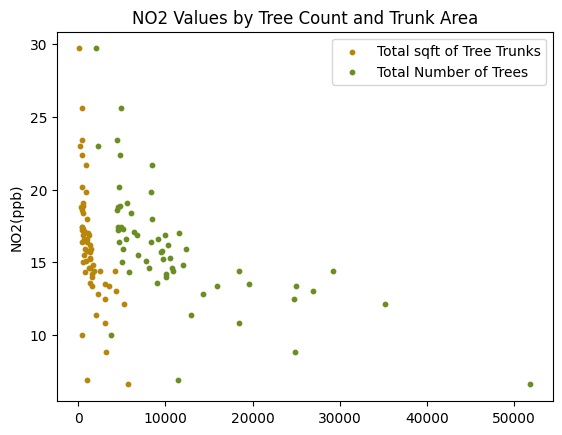

In [17]:
plt.scatter(tree_area_total["tree_area_sqft"], tree_area_total["NO2_value"], color= "#B8860B", s=10, label="Total sqft of Tree Trunks")
plt.scatter(tree_area_total["count"], tree_area_total["NO2_value"], color= "#6B8E23", s=10, label= "Total Number of Trees")
plt.legend()
plt.title("NO2 Values by Tree Count and Trunk Area")
plt.ylabel("NO2(ppb)")
plt.show()

Zooming out, and looking at the tree distribution between the larger 5 Boroughs of NYC:

In [18]:
boro_bar = px.bar(viz_boro, x= "boroname", y= "total_trees", title= "Trees per Borough in NYC", color_discrete_sequence=["#6B8E23"])
boro_bar.update_layout(xaxis_title= "NYC Borough", yaxis_title= "Tree Total")                                                                                                                 
boro_bar.show()

And... some people hate pie charts... some people love them.  

So, just for fun, here is a pie chart:

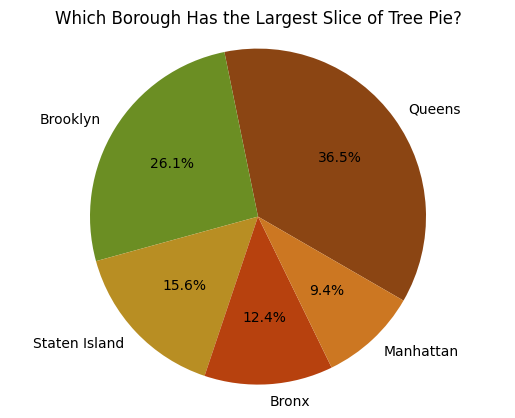

In [19]:
colors = ["#8B4513", "#6B8E23", "#B88E23", "#B7410E", "#CC7722"]
plt.pie(viz_boro["total_trees"], labels= viz_boro["boroname"], colors= colors, autopct= "%1.1f%%", startangle= 330)
plt.title("Which Borough Has the Largest Slice of Tree Pie?")
plt.axis("equal")
plt.show()

Next, please proceed to `project_summary.ipynb` for a summary of the project and a link to the Tableau dashboard.